Usage notes (i.e. rushed documentation)
- Need to define beta_rng even if h_0=0

In [13]:
#### Imports
import numpy as np
import pandas as pd
from main import WageModel
from matplotlib import pyplot as plt
import os, sys
import csv
from matplotlib import cm

## Run Simulation

Parameterize model; run this cell even if you're skipping to the analysis portion.

In [14]:
# Simulation parameters 
ucnames = ['UCM', 'UCR', 'UCD', 'UCLA', 'UCSD', 'UCB', 'UCI', 'UCSB', 'UCSC', 'UCSF']
reps = 1000
tstep = 1 # Years
tfinal = 2
meth = 'rent change skewed'
skew = -3
r = 0.3
num_steps = 3
step_inc = 0.03
a = np.arange(1, 1+step_inc*(num_steps-1), step_inc)
bw_0 = np.repeat(24.99e3,len(ucnames))

# beta_rng and alpha_rng can either be static (single num) or dynamic (list with min and max)
# ranges can be either global or per campus
stepwide_alp = False
# Time-independent
# alp_rng = 0.06
# alp_rng = [0.01,0.1]
# alp_rng = [[0.01,0.1], [0.01,0.1], [0.01,0.1], [0.01,0.1], [0.01,0.1],
#            [0.01,0.1], [0.01,0.1], [0.01,0.1], [0.01,0.1], [0.01,0.1]]
# Time-dependent
alp_rng = [0.126, 0.035]

# Flat stipend
h_0 = np.repeat(0, len(ucnames))
# Time-independent
# beta_rng = 0
# beta_rng = [0.03,0.12]
# beta_rng = [[0.01,0.02],[0.01,0.02],[0.01,0.05],[0.01,0.05],[0.01,0.08],
#             [0.01,0.08],[0.01,0.1],[0.01,0.1],[0.01,0.12],[0.01,0.12]]
# Time-dependent
beta_rng = [0., 0.]

y_max = 8
yf = np.array([2,4,5,6,y_max])
d = -0.06
y_grad = 3
S_tot = 1
rent_data = pd.read_csv('rent_data.csv')

Run the model

In [8]:
# Create csv for writing output
outfn = 'out.csv'
overwrite = True ### CAREFUL!
params = ['rep','t','k']
for i in range(len(a)):
    params.append('w_'+str(i))
params.append('h')
params.append('R')
if os.path.isfile(outfn) == True:
    if overwrite:
        os.remove(outfn)
    else:
        sys.exit('Set overwrite to True to overwrite existing output file')

# Run simulation
with open(outfn, 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(params)
    for rep in range(reps):
        params = {'a':a, 'bw_0':bw_0, 'alp_rng':alp_rng, 'stepwide_alp':stepwide_alp,
                  'h_0':h_0, 'beta_rng':beta_rng, 'r':r, 'yf':yf, 'y_max':y_max, 'd':d,
                  'd':d, 'y_grad':y_grad, 'S_tot':S_tot, 'rent_data':rent_data, 'meth':meth,
                  'rep':rep, 'rate_timeseries':True, 'skew':skew}
        model = WageModel(**params)
        model.runsim(outfile=outfile, tstep=tstep, tfinal=tfinal, verbose=False)
%tb

No traceback available to show.


## Analysis

Note this doesn't account for the contract actually starting in early 2023 and ending in Fall 2025. It just assumes the wage and contract years overlap exactly. It doesn't really make a difference. 

R_avgs(t=0) = [14916.0, 21012.0, 22212.0, 26664.0, 35280.0, 28860.0, 30468.0, 32004.0, 39516.0, 38256.0]
R_avgs(t=1) = [16035.948, 22226.08, 23587.402, 27221.054, 36137.691, 28618.52, 31183.448, 32924.415, 40375.51, 36193.977]
pct_change(t=1) = [ 7.50836685  5.7780316   6.19215739  2.08916142  2.43109694 -0.83672904
  2.34819483  2.87593738  2.17509363 -5.3900643 ]
R_avgs(t=2) = [17267.386, 23479.633, 25058.949, 27845.942, 37058.916, 28369.489, 31976.206, 33808.362, 41209.129, 34164.391]
pct_change(t=2) = [ 7.67923418  5.64000939  6.23869895  2.29560545  2.54920825 -0.87017428
  2.54223972  2.68477663  2.06466494 -5.60752415]


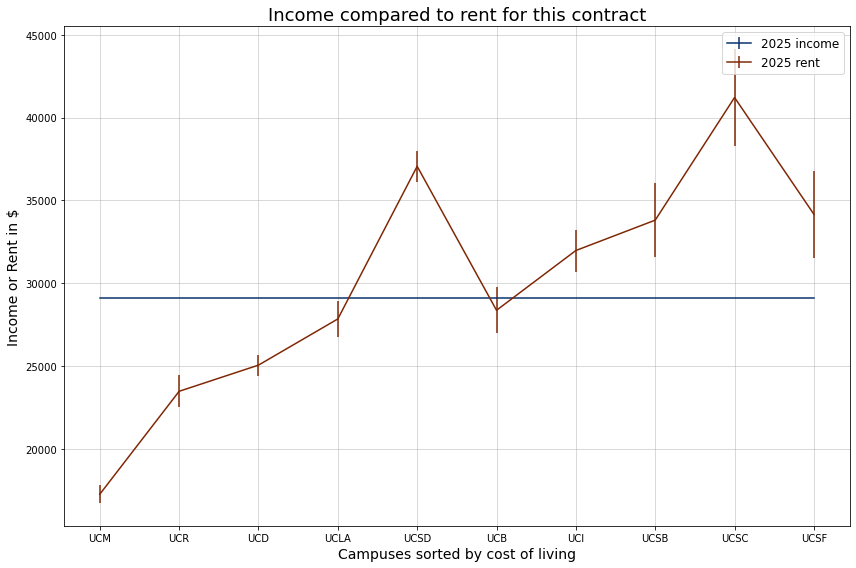

In [33]:
df = pd.read_csv('out.csv')

# An extremely naive way to simluate cost of living change
# current living wage data taken from MIT cost of living calculator
lw = np.array([34216. , 38812.8, 40934.4, 45531.2, 47299.2, 50460.8, 51833.6, 52665.6, 57075.2, 64084.8])
for t in range(2):
    lw = lw * 1.05
    
time = np.arange(0, tfinal+tstep, tstep)
y_0 = 2023 # Year contract begins

fig = plt.figure(figsize=(12,8))
colmap = cm.get_cmap('Blues', 12)
Rcolmap = cm.get_cmap('Oranges', 12)
R_all = []
pct_change_all = []
for i, t in enumerate(time):
    income_avgs = []
    income_stds = []
    R_avgs = []
    R_stds = []
    for k in range(len(bw_0)):
        df_sub = df[(df.t == t) & (df.k == k)]
        bw_avg, bw_std = np.mean(df_sub['w_0']), np.std(df_sub['w_0'])
        h_avg, h_std = np.mean(df_sub['h']), np.std(df_sub['h'])
        income_avg = bw_avg + h_avg
        income_avgs.append(income_avg)
        income_std = np.sqrt(bw_std**2 + h_std**2)
        income_stds.append(income_std)
        R_avg, R_std = np.mean(df_sub['R']), np.std(df_sub['R'])
        R_avgs.append(R_avg)
        R_stds.append(R_std)
    print('R_avgs(t={}) = {}'.format(t,R_avgs))
    R_all.append(np.array(R_avgs))
    if t > 0:
        pct_change = ((R_all[i]-R_all[i-1])/R_all[i-1])*100
        print('pct_change(t={}) = {}'.format(t, pct_change))
        pct_change_all.append(pct_change)
    if i == len(time)-1:
        plt.errorbar(ucnames,income_avgs,yerr=income_stds, 
                     label='{} income'.format(str(t+y_0)), c=colmap((i+1)/3))
        plt.errorbar(ucnames,R_avgs,yerr=R_stds, 
                     label='{} rent'.format(str(t+y_0)), c=Rcolmap((i+1)/3))
    #     plt.plot(ucnames,np.array(income_avgs)*0.3, ls='--', c=Rcolmap(i/3),
    #                 label='rent burden thresh year {}'.format(str(t)))

# plt.plot(ucnames,lw, c='red', label='Cost of living final year')
plt.grid(True,alpha=0.6)
plt.title('Income compared to rent for this contract', fontsize=18)
plt.ylabel('Income or Rent in $', fontsize=14)
plt.xlabel('Campuses sorted by cost of living', fontsize=14)
plt.tight_layout()
plt.legend(fontsize='large')
plt.savefig('UCpropsim.png', dpi=200, facecolor='white', transparent=False)
plt.show()

In [17]:
pct_change_all[0]

array([ 7.50836685,  5.7780316 ,  6.19215739,  2.08916142,  2.43109694,
       -0.83672904,  2.34819483,  2.87593738,  2.17509363, -5.3900643 ])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


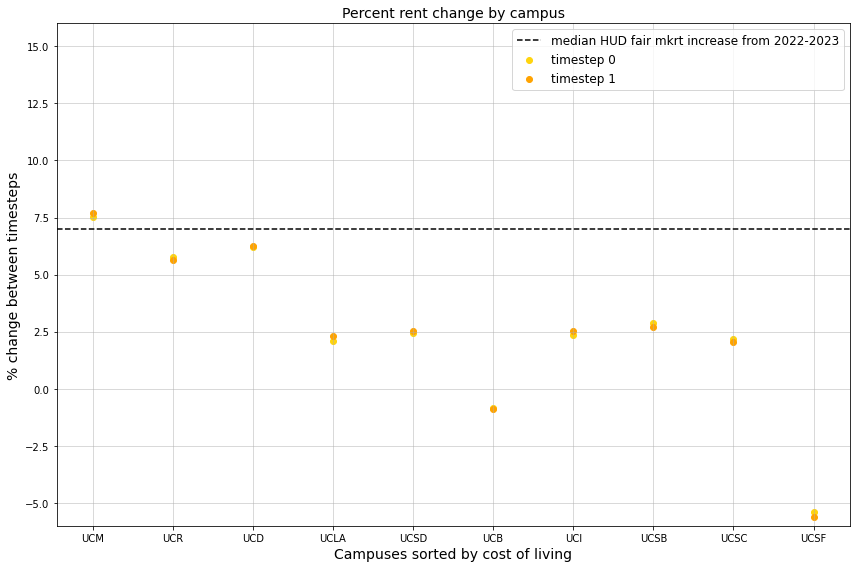

In [19]:
fig = plt.figure(figsize=(12,8))
Rcolmap = cm.get_cmap('Wistia', 12)
for i, pct_change in enumerate(pct_change_all):
    plt.scatter(ucnames, pct_change, label="timestep {}".format(i), c=Rcolmap((i+1)/3))
plt.axhline(7, ls='--', c='black', label="median HUD fair mkrt increase from 2022-2023")
plt.grid(True,alpha=0.6)
plt.title('Percent rent change by campus', fontsize=14)
plt.ylabel('% change between timesteps', fontsize=14)
plt.xlabel('Campuses sorted by cost of living', fontsize=14)
plt.ylim(-6,16)
plt.tight_layout()
plt.legend(fontsize='large')
plt.show()